In [15]:
import itertools
n = 12
G = BraidGroup(n,'s')
G_gens = G.gens()
from operator import mul
# from functools import reduce # python3 compatibility
b = reduce(mul, G.gens(), G_gens[0]**0)

True

In [20]:
rho_std(12)

[
[ 1 -1]  [1 0]  [ 1 -1]  [1 0]  [ 1 -1]  [1 0]  [ 1 -1]  [1 0]
[ 0  1], [1 1], [ 0  1], [1 1], [ 0  1], [1 1], [ 0  1], [1 1],

[ 1 -1]  [1 0]  [ 1 -1]  [1 0]
[ 0  1], [1 1], [ 0  1], [1 1]
]

In [24]:
BB = BraidGroup(2,'s')
F2 = FreeGroup(2)
F2_gens = F2.gens()
BB_gens = BB.gens()
scc_rep(twist_rho(BB_gens[0]**(-1)))
F2_gens[0]*BB_gens[0]

x0*x1*x0^-1

In [2]:
import curver

ModuleNotFoundError: No module named 'curver'

# Setup Cells

## Braid Group Action Setup

In [1]:
### FREE GROUP -> SL2Z and Rep Defns ### 
import math

def free_to_matrix(f, rho):
    res = rho[0]**0
    for i in f.Tietze():
        res = res * rho[abs(i)-1]**sgn(i)
    return res
    
A = matrix([[1,-1],[0,1]])
B = matrix([[1,0],[1,1]])
def rho_std(n):
    rho = []
    AA = matrix([[1,-1],[0,1]])
    BB = matrix([[1,0],[1,1]])
    for i in range(0,floor(n/2)):
        rho.append(AA)
        rho.append(BB)
    if n % 2 == 1:
        rho.append(AA)
    return rho

def conj_rho(S, rho):
    return list(map(lambda x: S * x * S**(-1), rho))

def rho_traces3(rho):
    [X,Y,Z] = rho
    return [(X*Y).trace(),(Y*Z).trace(),(X*Z).trace(),(X*Y*Z).trace()]

In [2]:
## Testing for Conj Reps ##

def test_conj_reps(lst_reps, lst_conjs,with_idx=False):
    lst_seen = []
    lst_with_idx = []
    helpful = []
    for (j,rho) in enumerate(lst_reps):
        conjs_of_rho = [(S,lst_seen.index(conj_rho(S,rho))) for S in lst_conjs if conj_rho(S,rho) in lst_seen]
        helpful = helpful + conjs_of_rho
        if with_idx:
            for (_,k) in conjs_of_rho:
                lst_with_idx[k][2].append(j)
        if not (rho in lst_seen) and not (conjs_of_rho):
            lst_seen.append(rho)
            if with_idx:
                lst_with_idx.append((rho,j,[]))
                
    if with_idx:
        return (helpful,lst_with_idx)
    else:
        return (helpful, lst_seen)

def lots_of_sl2(N):
    if N == 0:
        id_mat = matrix([[1,0],[0,1]])
        return [id_mat]
        
    sl2_gens = [A,B,A**(-1),B**(-1)]
    return [C*X for C in lots_of_sl2(N-1) for X in sl2_gens]

def lots_of_braid(gens,N):
    if N == 0:
        return [gens[0]**0]
        
    gens_with_inv = [b**e for e in [1,-1] for b in gens]
    return [C*X for C in lots_of_braid(gens,N-1) for X in gens_with_inv]

In [3]:
### Braid Group acting on Reps + Stabilizer Test ###

def twist_rho(b,rho = None):
    if rho == None:
        rho = rho_std(b.strands())
    the_gens = FreeGroup(b.strands()).gens()
    return [free_to_matrix(the_gens[i]*b,rho) for i in range(0,b.strands())]

@parallel
def braid_in_img(b, rho = None):
    if rho == None:
        rho = rho_std(b.strands())
    twisted = twist_rho(b,rho)
    return rho == twisted

def braid_in_img_p(b,p=2,rho=None):
    if rho == None:
        rho = rho_std(b.strands())
    twisted = twist_rho(b,rho)
    return [mat % p for mat in rho] == [mat % p for mat in twisted]

def braid_in_core_ex(b,reps):
    for rho in reps:
        if not braid_in_img(b,rho):
            return (False,rho)
    return (True, None)

def braid_in_core(b, reps):
    return all([braid_in_img(b,rho) for rho in reps])

def find_core_tech(reps,gens,N, not_in_core_ex = None):
    ident = gens[0] ** 0
    if not_in_core_ex == None:
        not_in_core_ex = []
    not_in_core = [b for (b,_) in not_in_core_ex]
    
    cands = []
    for b in lots_of_braid(gens,N):
        if b in not_in_core or b == ident:
            continue
        
        (_, rep) = braid_in_core_ex(b,reps)
        if rep:
            not_in_core_ex.append((b,rep))
            not_in_core.append(b)
        else:
            cands.append(b)
            
    return (cands, not_in_core, not_in_core_ex)

def find_core_cand(reps,gens,N):
    ident = gens[0] ** 0
    cands = []
    for b in lots_of_braid(gens,N):
        if b != ident and braid_in_core(b,reps):
            cands.append(b)
    return cands

## Orbit Graph Setup

In [4]:
def construct_orbit_hood(m, gens = None, rho = None,N=1000,M = 20, breadth=True, one_index_gen_names=False):
    if rho == None: 
        rho = rho_std(m)
    if gens == None:
        if one_index_gen_names:
            BGroup = BraidGroup(m, ['σ' + str(i) for i in range(1,m)])
        else:
            BGroup = BraidGroup(m, 'σ')
        gens = BGroup.gens()
    Gr = DiGraph(loops=True,multiedges=True)

    seen = [rho]
    new_vtxs = [(rho,0)]
    Gr.add_vertex()
    num_loops = 0
    i = 1
    completed_verts = []
    while new_vtxs and (i < N and num_loops < M):
        if breadth:
            (v,k) = new_vtxs.pop(0)
        else:
            (v,k) = new_vtxs.pop()
        for g in gens:
            w = twist_rho(g, v)
            if not (w in seen):
                seen.append(w)
                new_vtxs.append((w,i))
                j = i
                Gr.add_vertex()
                i += 1
            else:
                j = seen.index(w)
            Gr.add_edge(k,j, label=str(g))
        completed_verts.append(k)
        num_loops += 1
    return (Gr, gens, seen, i >= N or num_loops >= M,completed_verts,BGroup)


def display_orbit(graph, gens, completed_verts = None, loopless=True, edge_labels=True):
    m = len(gens)
    vert_dict = None
    if completed_verts:
        vert_dict = {}
        vert_dict[(0,1,0)] = completed_verts
        vert_dict[(1,0,0)] = [v for v in graph.vertices() if v not in completed_verts]
    bow = rainbow(m)
    color_dict = {str(gens[i]):bow[i] for i in range(0,m) }
    return graph.plot(edge_colors = graph._color_by_label(color_dict),edge_labels=edge_labels, vertex_colors = vert_dict)


def braid_from_path(path,gens):
    lst_of_elts = [gens[int(z[1:])] for (x,y,z) in path]
    res = gens[0] ** (0)
    for x in lst_of_elts:
        res = x * res
    return res


def from_Tietze_to_genlst(g,gens):
    tietze = g.Tietze()
    return [(gens[abs(i)-1], math.copysign(1,i)) for i in tietze]

def from_Tietze_to_gens(g, gens):
    return [h**j for (h,j) in from_Tietze_to_genlst(g,gens)] 

def from_Tietze(lst,gens):
    res = gens[0]**0
    for i in lst:
        j = 1 if i > 0 else -1
        res = res * (gens[abs(i)-1] ** j)
    return res

def edge_from_gen(Gr, v, gen, k=1):
    if k == 1:
        cands = [(i,j,e) for (i,j,e) in Gr.outgoing_edges(v) if e == str(gen)]
    elif k == -1:
        cands = [(i,j,e) for (i,j,e) in Gr.incoming_edges(v) if e == str(gen)]
    
    if cands:
        return cands[0]
    else:
        if k == 1:
            print(Gr.outgoing_edges(v),"\n")
        else:
            print(Gr.incoming_edges(v),"\n")
        print(v,"\n",gen,"\n",k,"\n",cands,"\n\n")
        return None

def path_from_genlst_noswp(Gr, lst, v):
    w = v
    result = []
    for (gen,i) in lst:
        e = edge_from_gen(Gr,w,gen,i)
        result.append((e,i))
        (new_w_back, new_w_forward, _) = e
        w = new_w_forward if i == 1 else new_w_back
    return result
    
def path_from_genlst(Gr, lst, v):
    def swap_if_neg(t, j):
        if j == 1:
            return t
        if j == -1:
            return (t[1], t[0], t[2] + "^(-1)")
    return [swap_if_neg(e,i) for (e,i) in path_from_genlst_noswp(Gr,lst,v)]

def path_from_braid(Gr, gens, v, g):
    genlst = from_Tietze_to_genlst(g,gens)
    genlst.reverse()
    return path_from_genlst(Gr, genlst, v)

def antinodal_at(Gr, v, gen):
    (i, j, e) = edge_from_gen(Gr,v,gen)
    if j == v:
        return None
    [(e1,_),(e2,_),(e3,_)] = path_from_genlst_noswp(Gr, 3*[(gen,1)],v)
    (k,l,ee) = e3
    if v == l:
        return [e1,e2,e3]
    return None

def equinodal_at(Gr, v, gen):
    (i,j,e) = edge_from_gen(Gr, v, gen)
    if j == v:
        return (i,j,e)
    else:
        return None

def path_conj_braid(Gr, gens, v, w):
    a_path = Gr.all_paths(v,w,report_edges=True,labels=True)[0]
    return braid_from_path(a_path,gens)

def get_equi_antinodals(Gr,v,gens):
    equis = []
    antis = []
    ident = gens[0]**0
    
    for w in Gr.vertices():
        b = ident if v == w else path_conj_braid(Gr, gens, v, w)
        for gen in gens:
            if antinodal_at(Gr,w,gen):
                antis.append(b**(-1)* gen**3 *b)
            elif equinodal_at(Gr,w,gen):
                equis.append(b**(-1)*gen*b)
    return (equis, antis)
        

## Huge Orbit Setup

In [5]:
def twist_all(g,reps):
    return [twist_rho(g,v) for v in reps]

def construct_huge_orbit(m, reps, gens = None,N=1000,M = 20, breadth=True):
    if gens == None:
        BGroup = BraidGroup(m, 'σ')
        gens = BGroup.gens()
    Gr = DiGraph(loops=True)

    seen = [reps]
    new_vtxs = [(reps,0)]
    Gr.add_vertex()
    num_loops = 0
    i = 1
    completed_verts = []
    while new_vtxs and (i < N and num_loops < M):
        if breadth:
            (v,k) = new_vtxs.pop(0)
        else:
            (v,k) = new_vtxs.pop()
        for g in gens:
            w = twist_all(g, v)
            if not (w in seen):
                seen.append(w)
                new_vtxs.append((w,i))
                j = i
                Gr.add_vertex()
                i += 1
            else:
                j = seen.index(w)
                
            Gr.add_edge(k,j, label=str(g))
        completed_verts.append(k)
        num_loops += 1
    return (Gr, gens, seen, i >= N or num_loops >= M,completed_verts)

## Finding Generators / Misc Group Stuff

In [6]:
import itertools as it

### Finite Generation from Finite Index ###

def same_left_coset(a,b, pred = braid_in_img):
    return pred(b**(-1) * a)
def same_right_coset(a,b, pred = braid_in_img):
    return pred(a * (b**(-1)))

def find_in_rcosets(g, rcosets, pred=braid_in_img):
    #print("    Finding for " + str(g))
    try:
        guy = next(filter(lambda x: same_right_coset(g,x,pred), rcosets))
    except:
        raise ValueError("Could not find a coset for " + str(g))
    #print("    Found: " + str(guy))
    return guy

def gens_one_rcoset(gens, cos_rep, rcosets,pred=braid_in_img):
    # print("### Working on Coset " + str(cos_rep) + " ###")
    return [cos_rep * g * (find_in_rcosets(cos_rep*g,rcosets,pred))**(-1) for g in gens]

def gens_from_rcosets(gens, rcosets, pred=braid_in_img):
    return [x for cos_rep in rcosets for x in gens_one_rcoset(gens,cos_rep,rcosets,pred)]

def rcosets_from_lcosets(lcosets):
    return list(map(lambda x: x**(-1), lcosets))

def gens_from_lcosets(gens,lcosets,pred=braid_in_img):
    rcosets = rcosets_from_lcosets(lcosets)
    return gens_from_rcosets(gens,rcosets,pred)

def build_lcosets(Gr, gens):
    lcosets = [gens[0] * gens[0]**(-1)]
    for v in Gr.vertices():
        if v != 0:
            path = next(Gr.all_paths_iterator([0],[v],report_edges=True, labels=True))
            lcosets.append(braid_from_path(path, gens))
    return lcosets

def build_stab_gens(Gr, gens, pred=braid_in_img):
    lcosets = build_lcosets(Gr,gens)
    return gens_from_lcosets(gens,lcosets,pred=braid_in_img)

# Some basic group theory helpers

def conj(g,h):
    return h * g * h**(-1)

def commutator(g,h):
    return g*h*(g**(-1)) * (h**(-1))

def all_commutators(lst):
    return [commutator(g,h) for (g,h) in it.combinations(lst,2)]


In [7]:
## Orbit Order with Braid Action ##

def find_orb_order(b,rho = None,N=1000):
    for i in range(1,N):
        if braid_in_img(b**i,rho):
            return i
    return None

## Dehn Twists in T^2 version

In [8]:
import itertools

def scc(v):
    x = math.gcd(v[0,0],v[1,0])
    return 1/x * v

def scc_from_matrix(A,simplify=True):
    e1 = matrix([[1],[0]])
    e2 = matrix([[0],[1]])
    
    c1 = A*e1 - e1
    c2 = A*e2 - e2
    if c1 != 0:
        return scc(c1) if simplify else c1
    elif c2 != 0:
        return scc(c2) if simplify else c2
    else:
        return None

def matrix_from_scc(c):
    e1 = matrix([[1],[0]])
    e2 = matrix([[0],[1]])
    v1 = e1 + alg_int_number(e1,c)*c
    v2 = e2 + alg_int_number(e2,c)*c
    return matrix([v1.transpose()[0], v2.transpose()[0]]).transpose()

def alg_int_number(v1,v2):
    M = matrix([[v1[0,0],v2[0,0]],[v1[1,0],v2[1,0]]])
    return M.det()

def int_number(v1,v2):
    return abs(alg_int_number(v1,v2))

def scc_rep(rho,simplify=True):
    return [scc_from_matrix(X,simplify=simplify) for X in rho]

A = matrix([[1,-1],[0,1]])
B =  matrix([[1,0],[1,1]])
def adj_int_numbers(rho):
    scc_rho = scc_rep(rho)
    return [int_number(v1,v2) for (v1,v2) in itertools.pairwise(scc_rho)]

def all_int_numbers(rho):
    scc_rho = scc_rep(rho)
    return [int_number(v1,v2) for (v1, v2) in itertools.combinations(scc_rho,2)]

In [9]:
H = BraidGroup(2)
H_gens = H.gens()
var('y','z')

inf = Infinity
def rat_to_curve(p):
    if p == Infinity:
        return matrix([[1],[0]])
    else:
        a = p.numerator()
        b = p.denominator()
        return matrix([[a], [b]])
def curve_to_rat(c):
    if c[1][0] == 0:
        return Infinity
    else:
        return c[0][0]/c[1][0]

def apply_braid_rat(b,ps):
    rep = [matrix_from_scc(rat_to_curve(p)) for p in ps]
    new_rep = twist_rho(b,rho=rep)
    sccs_rep = scc_rep(new_rep)
    return [curve_to_rat(c) for c in sccs_rep]


apply_braid_rat(H_gens[0]**(-1), [1,Infinity])

[+Infinity, 2]

In [10]:
var('x')
matrix_from_scc(matrix([[1],[x]]))


[ x + 1     -1]
[   x^2 -x + 1]

## Hyperbolic Geometry

In [11]:
def farey_next(t1,t2):
    (a,b,alpha) = t1
    (c,d,beta) = t2
    (x,y) = (a+c,b+d)
    k = gcd(x,y)
    return (x/k,y/k,N((alpha+beta)/2))

def farey_seqs(n):
    if n == 0:
        return [[(0,1,0),(1,0,pi)]]
    result = farey_seqs(n-1)
    farey_last = result[-1]
    next_farey = []
    farey_len = len(farey_last)
    
    for i in range(0,farey_len):
        next_farey.append(farey_last[i])
        if i < (farey_len-1):
            next_farey.append(farey_next(farey_last[i],farey_last[i+1]))
    
    return result + [next_farey]

def farey_angles(n):
    result = {}
    for (a,b,theta) in farey_seqs(n):
        result[(a,b)] = theta
    return result

def farey_seq(n):
    return [(a,b) for (a,b,_) in farey_seqs(n)[n-1]]

def pair_to_PD_point(t,H):
    UHP = H.UHP()
    PD = H.PD()

    (a,b) = t
    if b == 0:
        return PD.get_point(0.9999*I)
    else:
        return UHP.get_point(a/b+0.00001).to_model("PD")
    
def angle_to_PD_point(theta,H):
    PD = H.PD()
    return PD.get_point(0.999*exp(I*theta))

def farey_complex(H,n,mark_pts=[],make_dict=False):
    PD = H.PD()
    farey_pts_half = [[(a,b,angle_to_PD_point(theta,H)) for (a,b,theta) in lst] for lst in farey_seqs(n)]
    other_half = [[(-a,b,PD.get_point(pt.coordinates().conjugate())) for (a,b,pt) in lst] for lst in farey_pts_half]
    farey_pts = [lst1 + lst2 for (lst1,lst2) in zip(farey_pts_half,other_half)]
    
    mark_hyp_pts = [pair_to_PD_point(t,H) for t in mark_pts]
    farey_arcs = [H.PD().get_geodesic(p[2],q[2]) for lst in farey_pts for (p,q) in itertools.pairwise(lst)]
    #farey_arcs.append(H.PD().get_geodesic(farey_pts[-1],farey_pts[0]))
    farey_pts_dict = None
    if make_dict:
        farey_pts_dict = {}
        for (a,b,pt) in farey_pts[-1]:
            #z = pt.coordinates()
            #conj_pt = PD.get_point(z.conjugate())
            farey_pts_dict[(a,b)] = pt
            farey_pts_dict[(-a,-b)] = pt
            #farey_pts_dict[(-a,b)] = conj_pt
            #farey_pts_dict[(a,-b)] = conj_pt
        return (farey_arcs,mark_hyp_pts,farey_pts_dict)
    return (farey_arcs, mark_hyp_pts)

def display_farey(arcs,points,model="PD",arc_color="black"):
    new_arcs = [arc.to_model(model).plot(color=arc_color) for arc in arcs]
    new_pts = [pt.to_model(model).show(**opts) for (pt,opts) in points]
    res = new_arcs[0]
    for x in (new_arcs + new_pts)[1:]:
        res += x
    return res

def farey_with_curves(n=4,marked_curves=[],model="PD",preloaded=None):
    if preloaded:
        (farey_arcs, _, farey_pts_dict) = preloaded
    else:
        H = HyperbolicPlane()
        (farey_arcs, _, farey_pts_dict) = farey_complex(H,n,make_dict=True)
    return display_farey(farey_arcs, [(farey_pts_dict[t],opts) for (t,opts) in marked_curves],model=model)

In [12]:
def farey_rho(rho,opts=None,preloaded=None):
    SCCs = [(s[0][0],s[1][0]) for s in scc_rep(rho)]
    if not preloaded:
        n = 0
        while not (all([s in farey_seq(n) for s in SCCs])):
            n += 1
        H = HyperbolicPlane()
        preloaded = farey_complex(H,n,make_dict=True)
    m = len(SCCs)
    color_dict = rainbow(m)
    SCCs_opts = [(s,{"color": c, "size": (i+1)*70, "alpha": 0.5}) for (s,c,i) in zip(SCCs,color_dict,range(0,m))]
    return farey_with_curves(marked_curves=SCCs_opts,preloaded=preloaded)

In [13]:
import random
def farey_dist_tri_lst(lst):
    if len(lst) == 1:
        if lst[0] == 1:
            return 1
        else:
            return 2
    
    if lst[0] == 1:
        return farey_dist_tri_lst([1+lst[1]] + lst[2:])
    else:
        return farey_dist_tri_lst(lst[1:]) + 1

def farey_dist_infty(q):
    if q == Infinity:
        return 0
    elif q == 0 or q == 1:
        return 1
    elif 0 < q <= 1:
        continued_frac = list(abs(q).continued_fraction())
        return farey_dist_tri_lst(continued_frac)
    else:
        return farey_dist_infty(frac(abs(q)))

def mat_to_infty(r):
    if r == Infinity:
        return identity_matrix(2)
    p = r.numerator()
    q = r.denominator()
    _, a, b = xgcd(p,q)
    return matrix([[a,-b],[-q,p]])

def mat_on_rat(A,r):
    return curve_to_rat(A*rat_to_curve(r))

def farey_dist(p,q):
    A = mat_to_infty(p)
    return farey_dist_infty(mat_on_rat(A,q))

def farey_prod_dist(ps,qs):
    return sum([farey_dist(p,q) for (p,q) in zip(ps,qs)])

def braid_stretch(b,ps,qs):
    dist_before = farey_prod_dist(ps,qs)
    ps_new = apply_braid_rat(b,ps)
    qs_new = apply_braid_rat(b,qs)
    dist_new = farey_prod_dist(ps_new,qs_new)
    if dist_before == 0:
        return 0
    return dist_new/dist_before

def rand_ps(n,N=100):
    def rand_rat():
        a = random.randint(-N,N)
        b = random.randint(-N,N)
        if b == 0:
            return Infinity
        else:
            c = Rational(a/b)
            return c
    return [rand_rat() for i in range(0,n)]

def rand_braid_stretch(b,N=100):
    ps = rand_ps(b.strands(),N)
    qs = rand_ps(b.strands(),N)
    stretch = braid_stretch(b,ps,qs)
    return (ps, qs, stretch)

def many_rand_stretch(b,M=100,N=100,onlymax=True,printer=True):
    stretches = []
    for i in range(0,M):
        (ps, qs, stretch) = rand_braid_stretch(b,N)
        if not(onlymax) and printer:
            print("Trial ", i)
            print("  - ps = ", ps)
            print("  - qs = ", qs)
            print("  - stretch = ", stretch)
            print("")
        stretches.append(numerical_approx(stretch,digits=3))
    max_stretch = max(stretches)
    if printer:
        print("Max Stretch: ", max_stretch)
    return max_stretch

def matrix_stretch(mat,p):
    q = mat_on_rat(mat,p)
    return farey_dist(p,q)
    
def many_rand_mat_stretch(mat,M=100,N=100):
    ps = rand_ps(M,N)
    return max([matrix_stretch(mat,p) for p in ps])

# Example Graphs

81
26
21


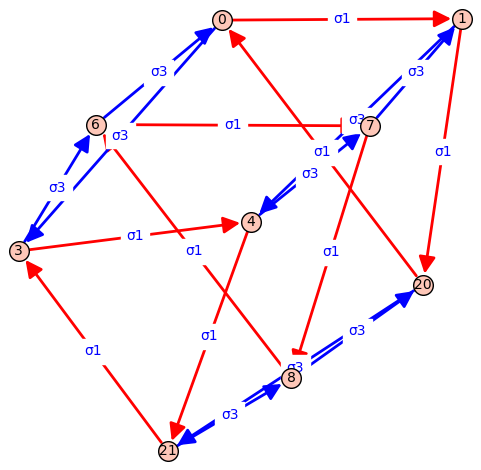

In [19]:
(Gr, gens, reps, timeout,comp_verts,_) = construct_orbit_hood(4,M=50,breadth=False,one_index_gen_names=True)
if timeout:
    print("Ran Out of Time")
#print(len(Gr.vertices()))
import sage.graphs.spanning_tree as spanning_tree
print(len(Gr.edges()))
print(len(spanning_tree.boruvka(Gr.to_undirected(),by_weight=False)))
Gr = Gr.subgraph([0,3,4,7,8,20,1,21,6])
print(len(Gr.edges()))
Gr.remove_loops()
display_orbit(Gr, gens,edge_labels=True).show(figsize=[1*6.4,1*4.8])

#stab_gens = build_stab_gens(Gr,gens)
#identity = gens[0]*gens[0]**(-1)
#stab_gens = [s for s in stab_gens if s != identity]
#(huge_Gr, _, rreps, timeout, comp_verts2) = construct_huge_orbit(4,reps,gens=stab_gens)
#huge_Gr.remove_loops()
#display_orbit(huge_Gr, stab_gens, edge_labels=False).show(figsize=[2*6.4,2*4.8])

## Since we know that Core(G_4) = <<sigma^3>>
stab_gens = [s for s in stab_gens if not (s.is_conjugated(gens[0]**3))]

def only_one(e,g = stab_gens[13]):
    return e[2] == str(g)
all_graphs = [huge_Gr.subgraph(edge_property = lambda e: only_one(e,g)) for g in stab_gens]
#for gr in all_graphs:
    #display_orbit(gr, stab_gens, edge_labels=False).show(figsize=[1*6.4,1*4.8])
display_orbit(all_graphs[38], stab_gens, edge_labels=False).show(figsize=[2*6.4,2*4.8])

In [26]:
(Gr, gens, reps4, timeout,comp_verts,_) = construct_orbit_hood(3,M=50,breadth=False)
if timeout:
    print("Ran Out of Time")
#print(len(Gr.vertices()))
#Gr = Gr.subgraph([0,3,4,7,8,20,1,21,6])
Gr.remove_loops()
#display_orbit(Gr, gens).show(figsize=[1.5*6.4,1.5*4.8])

In [36]:
(Gr, gens, reps3, timeout,comp_verts,_) = construct_orbit_hood(4,N=2000,M=100,breadth=False)
if timeout:
    print("Ran Out of Time")
print(len(Gr.vertices()))
#Gr = Gr.subgraph([0,3,4,7,8,20,1,21,6])
#Gr.remove_loops()
#display_orbit(Gr, gens).show(figsize=[1.2*6.4,1.2*4.8])
#print(len(Gr.edges()))
(blah,blah2) = get_equi_antinodals(Gr, 0,gens)
#def long_prod(s,t,m):
#    res = s**0
#    for i in range(0,m):
#        if i % 2 == 0:
#            res = res*s
#        else:#
#            res = res*t
#    return res
#def find_m(s,t,N=200):
#    for m in range(1,N):
#        if long_prod(s,t,m) == long_prod(t,s,m):
#            return m
#    return None
#g = gens[0]**3
#h = gens[0]**(-1) * gens[1] * gens[0]
#k = gens[2] * gens[1] * gens[2]**(-1)
#print(find_m(g,k))
meow = [b.burau_matrix(reduced=True) for b in blah+blah2]
def find_weird(guys,N=10):
    e = guys[0] ** 0
    k = len(guys)
    guys_idxs = [i * j for j in range(1,k) for i in [-1,1]]
    combos = itertools.combinations_with_replacement(guys_idxs,N)
    for c in combos:
        g = from_Tietze(c,guys)
        if g != e:
            M = g.burau_matrix()
            I = identity_matrix(M.nrows())
            if M == I:
                return g
    return None
find_weird(blah+blah2,4)

27


*** longjmp causes uninitialized stack frame ***: terminated


GAPError: Error, no method found! Error, no 1st choice method found for `*' on 2 arguments

In [2]:
print(braid_in_img(blah[0]))
for x in blah + blah2:
    #print(path_from_braid(Gr, gens, 0, x))

SyntaxError: incomplete input (1318694256.py, line 3)

In [21]:
(Gr, gens5, reps5, timeout,comp_verts,_) = construct_orbit_hood(5,M=300,breadth=True)
if timeout:
    print("Ran Out of Time")
print(len(Gr.vertices()))
Gr.remove_loops()
#display_orbit(Gr, gens,completed_verts=comp_verts).show(figsize=[1*6.4,1*4.8])
#Gr.allow_loops(False)

Ran Out of Time
372


[([
[1 0]  [1 0]  [ 0 -1]  [ 2 -1]  [1 0]
[1 1], [1 1], [ 1  2], [ 1  0], [1 1]
],
  2),
 ([
[1 0]  [ 1 -1]  [ 3 -1]  [1 0]  [1 0]
[1 1], [ 0  1], [ 4 -1], [1 1], [1 1]
],
  2),
 ([
[ 1 -1]  [ 3 -1]  [1 0]  [1 0]  [1 0]
[ 0  1], [ 4 -1], [1 1], [1 1], [1 1]
],
  2),
 ([
[1 0]  [1 0]  [1 0]  [-1 -1]  [ 1 -1]
[1 1], [1 1], [1 1], [ 4  3], [ 0  1]
],
  2),
 ([
[1 0]  [1 0]  [-2 -1]  [ 0 -1]  [1 0]
[1 1], [1 1], [ 9  4], [ 1  2], [1 1]
],
  2),
 ([
[1 0]  [ 0 -1]  [ 2 -1]  [1 0]  [1 0]
[1 1], [ 1  2], [ 1  0], [1 1], [1 1]
],
  2),
 ([
[1 0]  [-1 -1]  [ 1 -1]  [1 0]  [1 0]
[1 1], [ 4  3], [ 0  1], [1 1], [1 1]
],
  2),
 ([
[-1 -1]  [ 1 -1]  [1 0]  [1 0]  [1 0]
[ 4  3], [ 0  1], [1 1], [1 1], [1 1]
],
  2),
 ([
[1 0]  [1 0]  [1 0]  [-3 -1]  [-1 -1]
[1 1], [1 1], [1 1], [16  5], [ 4  3]
],
  2),
 ([
[1 0]  [1 0]  [-1 -1]  [ 1 -1]  [1 0]
[1 1], [1 1], [ 4  3], [ 0  1], [1 1]
],
  2),
 ([
[1 0]  [1 0]  [-4 -1]  [-2 -1]  [1 0]
[1 1], [1 1], [25  6], [ 9  4], [1 1]
],
  2),
 ([
[1 0]  [1 0]  [1 

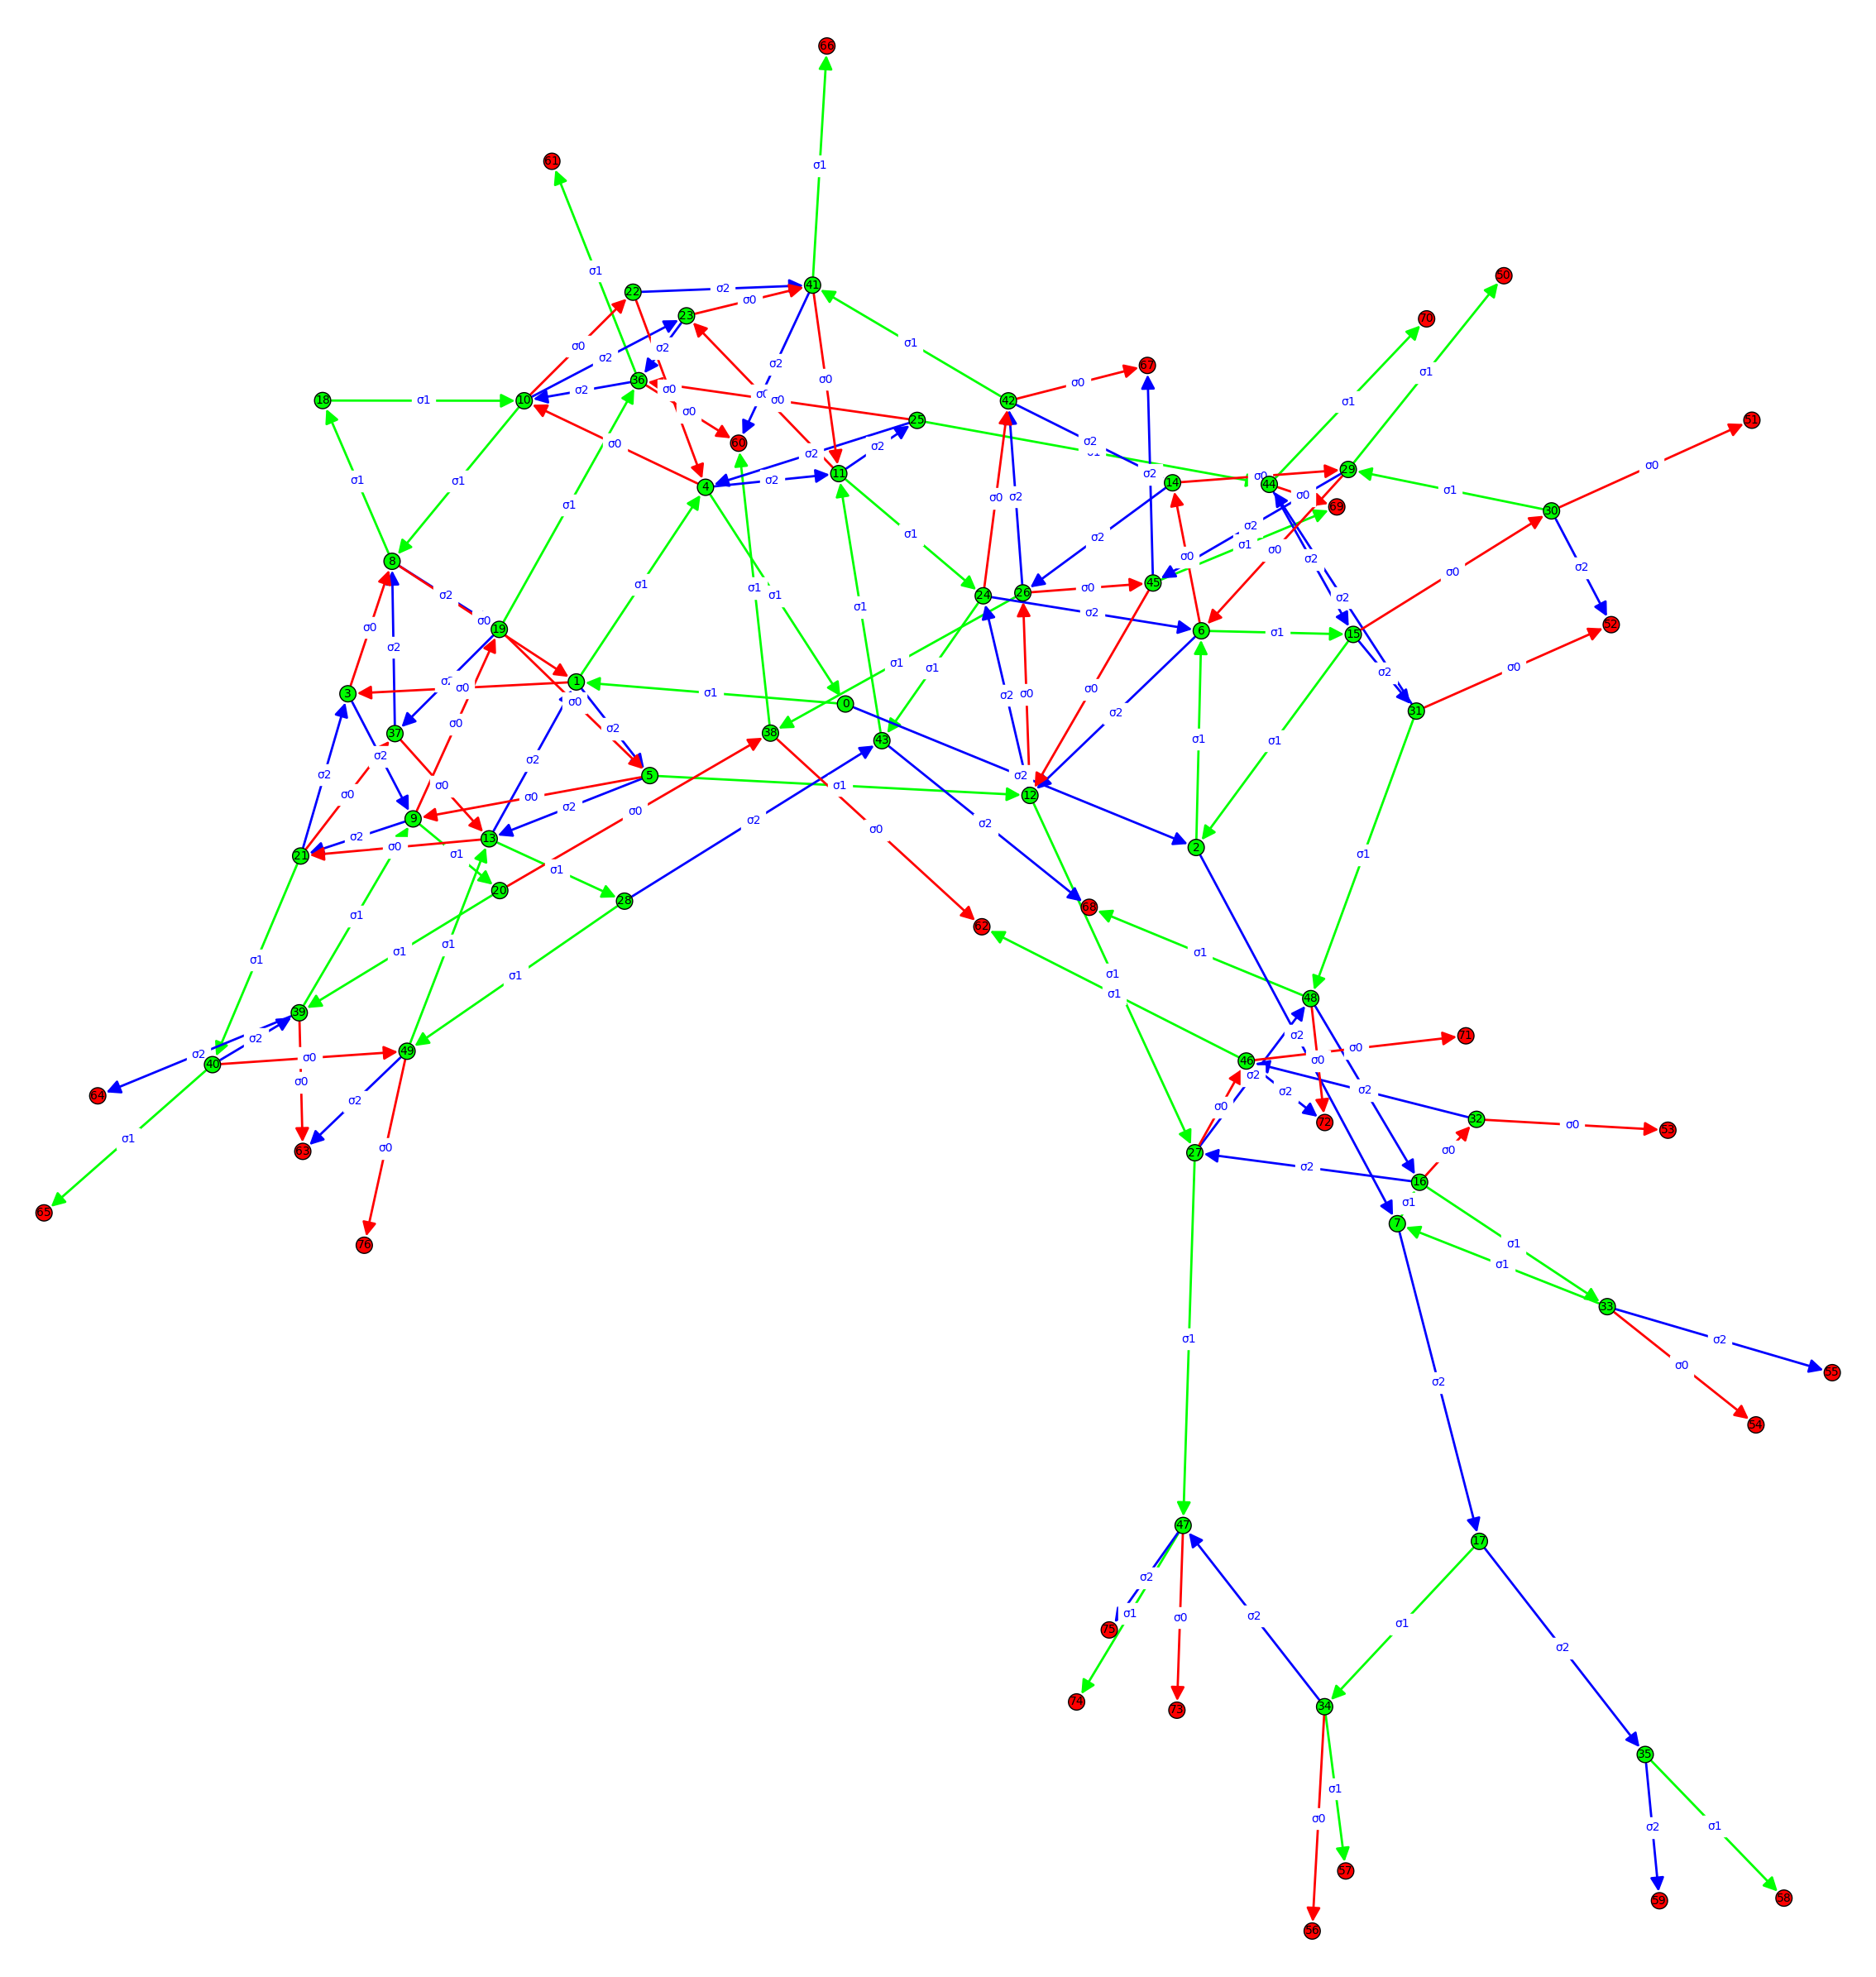

In [26]:
rho_4_weird = nice_rep[0:4]
(Gr4_weird, gens4_weird, reps4_weird, timeout, comp_verts, _) = construct_orbit_hood(4,M=50,breadth=True, rho = rho_4_weird)
Gr4_weird.remove_loops()
display_orbit(Gr4_weird, gens4_weird,completed_verts=comp_verts).show(figsize=[5*6.4,5*4.8])


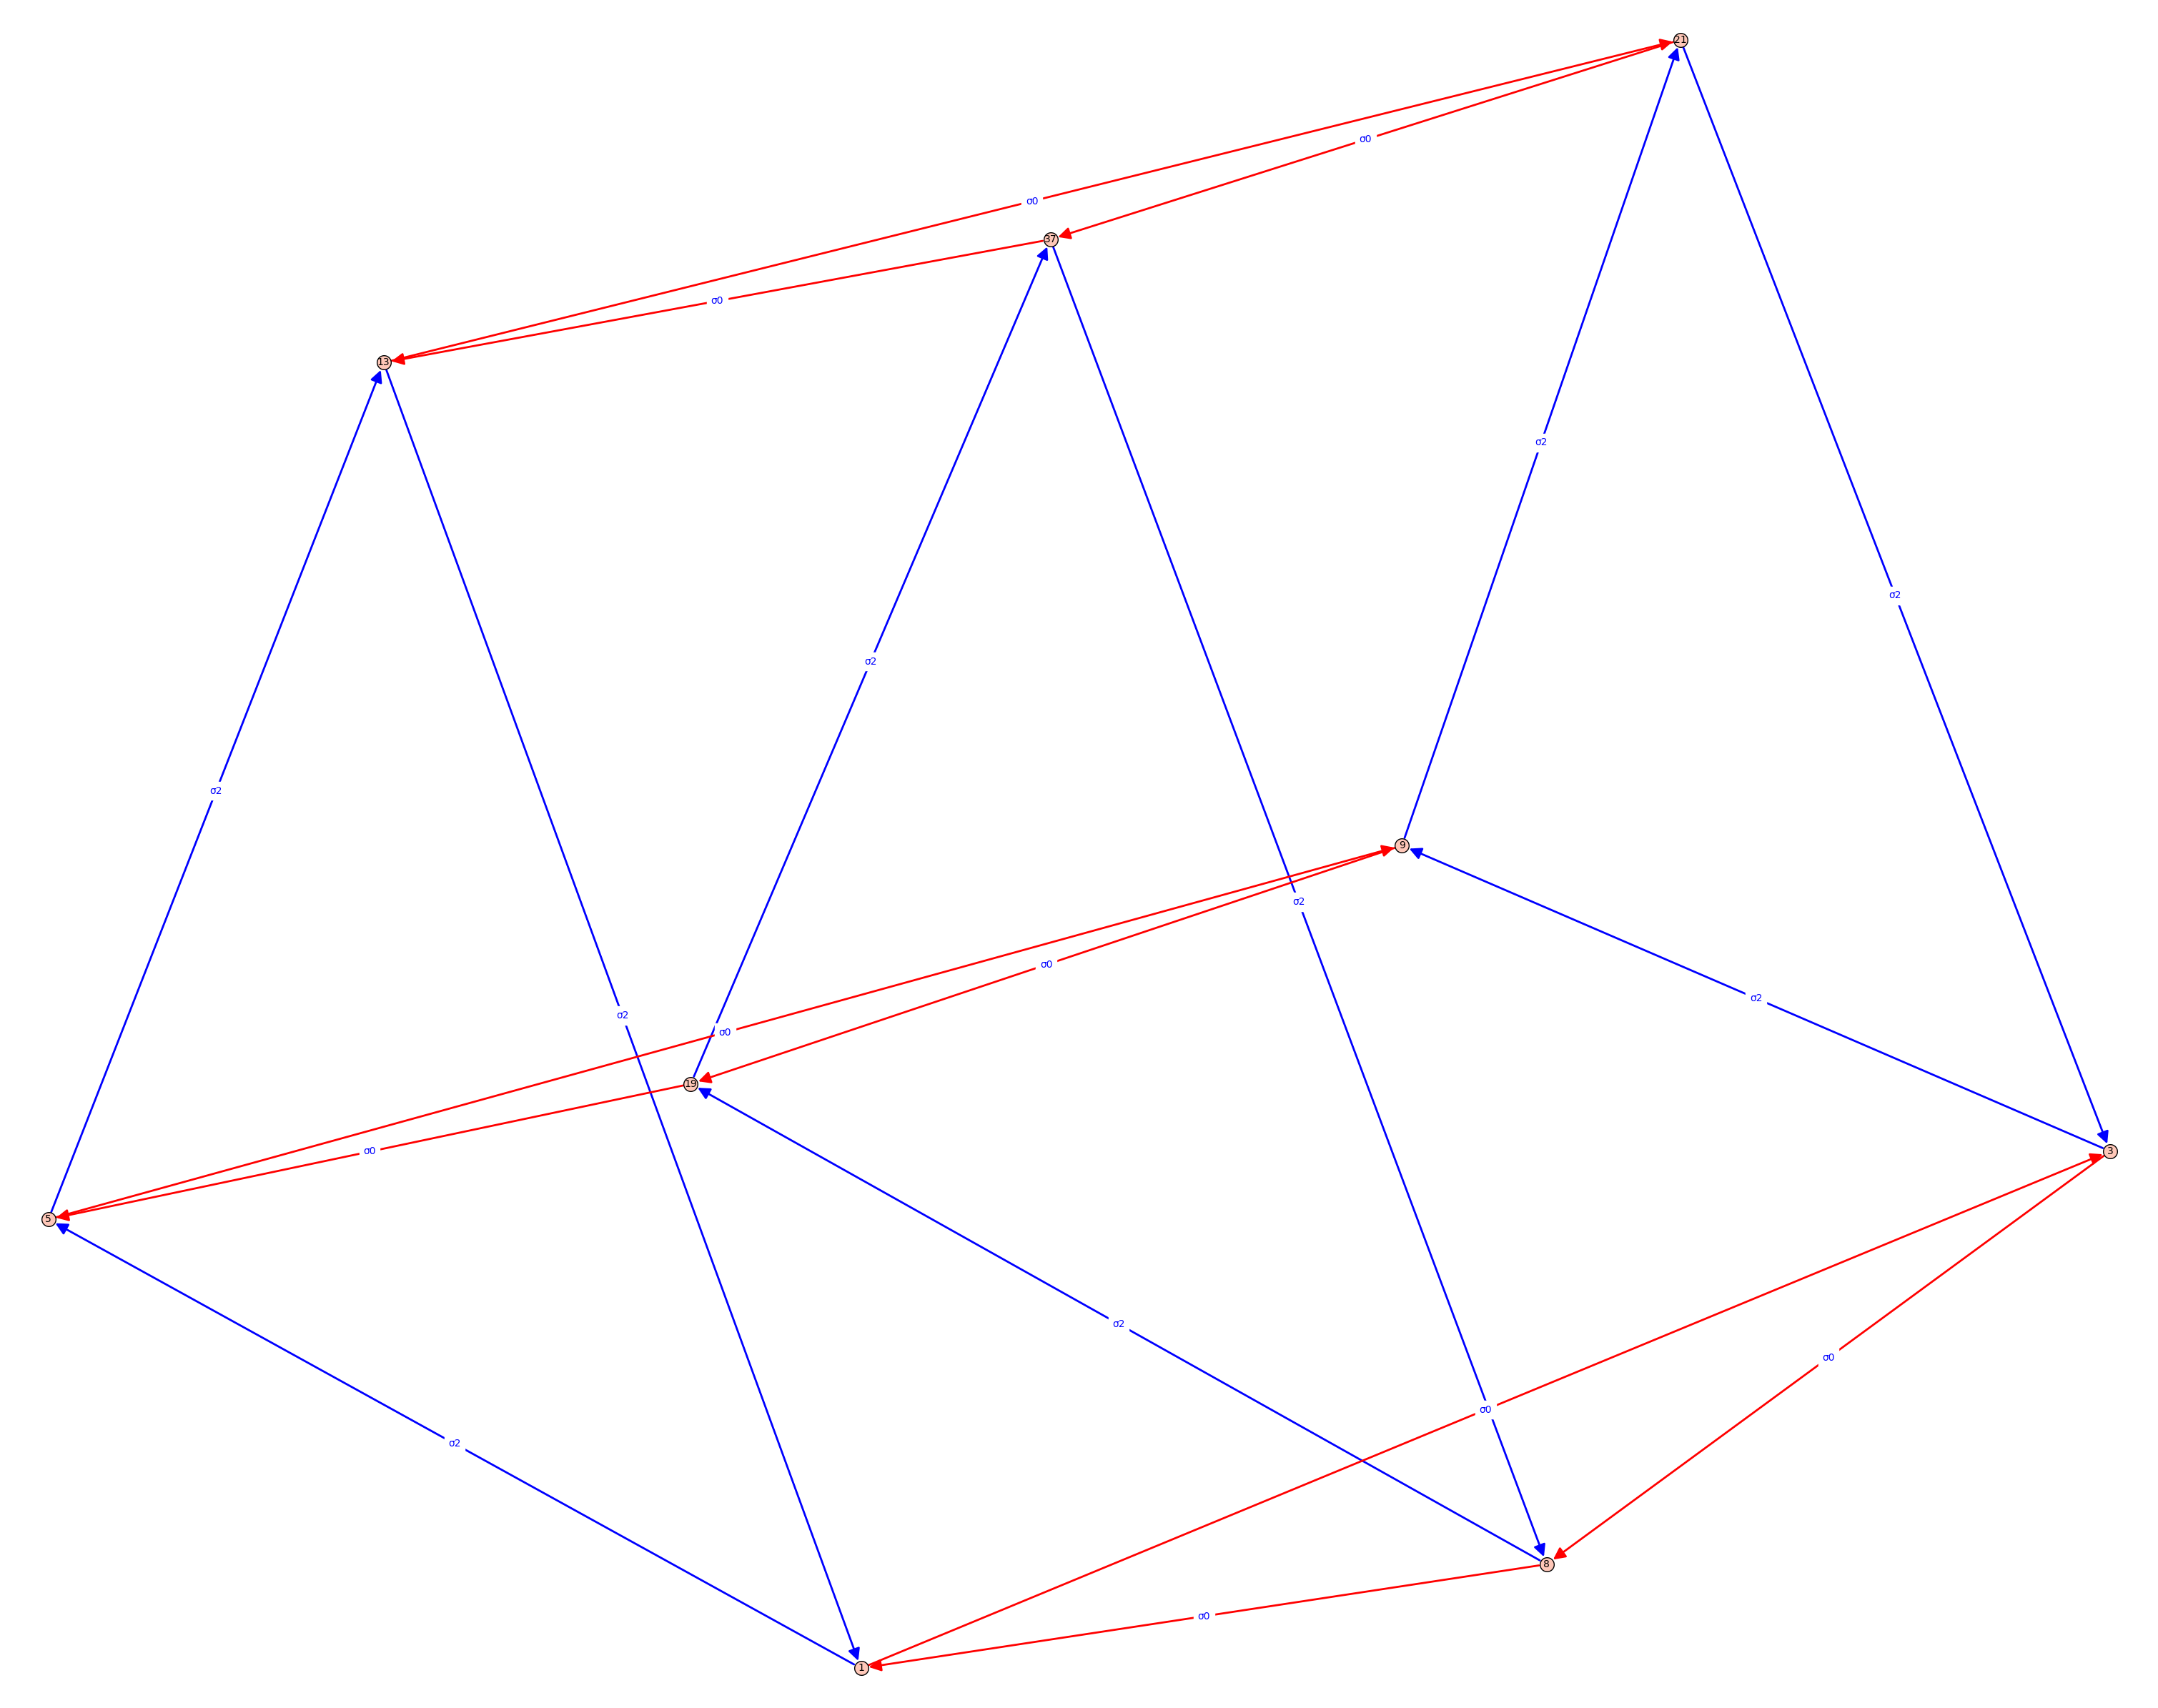

In [33]:
meow = Gr4_weird.subgraph([1,5,13,37,9,19,21,3,8])
display_orbit(meow, gens4_weird).show(figsize=[5*6.4,5*4.8])

In [34]:
(core_cand, not_core, not_core_ex) = find_core_tech(reps5,gens5,5)
core_cand

[]

In [9]:
#find_core_tech(reps5,gens5,6)

# Scratchpad

In [115]:
def central(gens):
    m = len(gens) + 1
    prod = gens[0]**0
    for g in gens:
        prod = prod * g
    return prod

In [116]:
rep_free = [matrix([[1,-2],[0,1]]), matrix([[1,0],[2,1]])]
new_rep = rep_free

## Infinite Stuff

In [17]:
a_path = Gr.all_paths(0,21,report_edges=True,labels=True)[0]
ell = braid_from_path(a_path,G_gens)

In [416]:
Gr.longest_path(algorithm="heuristic").edges()

[(10, 13, 'σ2'), (13, 16, 'σ3'), (16, 18, 'σ3'), (18, 19, 'σ0'), (19, 21, 'σ1'), (21, 24, 'σ3'), (24, 27, 'σ3'), (27, 29, 'σ2'), (29, 32, 'σ3'), (32, 35, 'σ3'), (35, 37, 'σ2'), (37, 40, 'σ3'), (40, 43, 'σ3'), (43, 45, 'σ2'), (45, 48, 'σ3'), (48, 51, 'σ3'), (51, 53, 'σ2'), (53, 56, 'σ3'), (56, 59, 'σ3'), (59, 61, 'σ2'), (61, 64, 'σ3'), (64, 66, 'σ2'), (0, 4, 'σ3'), (4, 8, 'σ3'), (8, 10, 'σ1')]

In [453]:
c = G_gens[0]*G_gens[1]
braid_in_img(c**(-1) * G_gens[1]**3 * c)

True

In [4]:
lcosets_3 = [G_gens[0]**0, G_gens[1],G_gens[0]*G_gens[1], G_gens[1]*G_gens[0]*G_gens[1],
             G_gens[0], G_gens[1]**2, G_gens[0]**2 * G_gens[1], G_gens[1]**2*G_gens[0]*G_gens[1]]
sub_gens = gens_from_lcosets(G_gens, lcosets_3)
#for g in sub_gens:
 #   g.plot().show()

NameError: name 'gens_from_lcosets' is not defined

In [19]:
(Gr_cyc, gens_cyc, _,comp_verts) = construct_orbit_hood(5,[ell**(-1) *G_gens[3]**(-1)*G_gens[2]*ell], M=1000,breadth=False)
print(len(Gr_cyc.vertices()))
Gr_cyc.remove_loops()
#display_orbit(Gr_cyc, gens_cyc,edge_labels=False, completed_verts=comp_verts).show(figsize=[5*6.4,5*4.8])
Gr_cyc.allow_loops(False)
print("")

1001



In [19]:
from_ell = G_gens[3]**(-1) * G_gens[2]
special = ell**(-1) * from_ell * ell
#find_orb_order(special)

In [11]:
ell

s1*s0*s3^2*s2*s1*s3^2

In [18]:
twist_rho(ell)

[
[1 0]  [1 0]  [ 1 -1]  [ 2 -1]  [ 3 -1]
[1 1], [1 1], [ 0  1], [ 1  0], [ 4 -1]
]

In [21]:
def some_niceties(m):
    return twist_rho(from_ell**m,twist_rho(ell))
def last_two(m):
    rho_lst = some_niceties(m)
    return rho_lst[-2]*rho_lst[-1]

In [92]:
def check_special_sim(X,Y,N=1000):
    for i in range(-N,N):
        P = matrix([[1,0],[i,1]])
        if P*X*(P**(-1)) == Y:
            return (True,i)
    return False
check_special_sim(some_niceties(2)[2], some_niceties(12)[2])

(True, 15)

In [4]:
var('p')
var('q')
def make_ind_mat(x):
    return matrix([[x,-1],(x-1)**2,-(x-2)])
P = matrix([[p,-1],[(p-1)**2, -(p-2)]])
Q = matrix([[q,-1],[(q-1)**2, -(q-2)]])
simplify(expand(P**(-1)*Q*(P)))

[                    p^3 - 2*p^2*q + p*q^2 - 2*p^2 + 2*p*q + 2*p - q                                  -p^2 + 2*p*q - q^2 + 2*p - 2*q - 1]
[p^4 - 2*p^3*q + p^2*q^2 - 2*p^3 + 2*p^2*q + 3*p^2 - 2*p*q - 2*p + 1                -p^3 + 2*p^2*q - p*q^2 + 2*p^2 - 2*p*q - 2*p + q + 2]

In [31]:
P_plus_one = matrix([[p+1,-1],[(p)**2, -(p-1)]])
P_minus_one = matrix([[p-1,-1],[(p-2)**2, -(p-1-2)]])
P_minus_two = matrix([[p-2,-1],[(p-3)**2, -(p-2-2)]])
factor(simplify(expand(P_plus_one**(-1)*P_minus_one * P_plus_one)))
factor(simplify(expand(P*P_plus_one * P**(-1))))

[1 0]
[1 1]

In [6]:
expand((B)*P*(B**(-1)))

[ p + 1     -1]
[   p^2 -p + 1]

## Conjugacy Questions / Computations

In [25]:
var('k')
K = matrix([[1,-1],[0,1]])
C = matrix([[0,-1],[1,2]])
D = matrix([[2,-1],[1,0]])
J = A*B*K
(A*B*K)*C*((A*B*K)**(-1))
(A*B*K)*A*(A*B*K)**(-1)
#conj_rho(J,twist_rho(G_gens[1],rho_std(3)))

[1 0]
[1 1]

In [16]:
twist_rho(G_gens[0]**2)

[
[1 0]  [ 0 -1]  [ 1 -1]
[1 1], [ 1  2], [ 0  1]
]

In [53]:
conj_lst = [matrix([[1,1],[-1,0]]),matrix([[0,-1],[1,1]])]
(helpers,alst) = test_conj_reps(reps, conj_lst,with_idx=True)

In [54]:
len(alst)

9

In [55]:
alst

[([
[ 1 -1]  [1 0]  [ 1 -1]  [1 0]
[ 0  1], [1 1], [ 0  1], [1 1]
],
  0,
  [4, 8]),
 ([
[ 0 -1]  [ 1 -1]  [ 1 -1]  [1 0]
[ 1  2], [ 0  1], [ 0  1], [1 1]
],
  1,
  [6, 21]),
 ([
[ 1 -1]  [ 2 -1]  [1 0]  [1 0]
[ 0  1], [ 1  0], [1 1], [1 1]
],
  2,
  [14, 26]),
 ([
[ 1 -1]  [1 0]  [ 0 -1]  [ 1 -1]
[ 0  1], [1 1], [ 1  2], [ 0  1]
],
  3,
  [7, 20]),
 ([
[ 1 -1]  [ 1 -1]  [1 0]  [ 1 -1]
[ 0  1], [ 0  1], [1 1], [ 0  1]
],
  5,
  [9, 17]),
 ([
[ 0 -1]  [1 0]  [ 0 -1]  [ 0 -1]
[ 1  2], [1 1], [ 1  2], [ 1  2]
],
  10,
  [18, 22]),
 ([
[ 0 -1]  [ 0 -1]  [-1 -4]  [ 1 -1]
[ 1  2], [ 1  2], [ 1  3], [ 0  1]
],
  11,
  [15, 23]),
 ([
[ 0 -1]  [ 0 -1]  [ 0 -1]  [-1 -4]
[ 1  2], [ 1  2], [ 1  2], [ 1  3]
],
  12,
  [16, 24]),
 ([
[-1 -1]  [ 0 -1]  [ 0 -1]  [ 0 -1]
[ 4  3], [ 1  2], [ 1  2], [ 1  2]
],
  13,
  [19, 25])]

In [49]:
id(True)

134250921431136

In [50]:
if []:
    

AttributeError: 'list' object has no attribute 'empty'

In [66]:
reps[6]

[
[ 1 -1]  [1 0]  [1 0]  [ 0 -1]
[ 0  1], [1 1], [1 1], [ 1  2]
]

In [70]:
twist_rho(G_gens[2])

[
[ 1 -1]  [1 0]  [ 0 -1]  [ 1 -1]
[ 0  1], [1 1], [ 1  2], [ 0  1]
]

In [76]:
reps[25]

[
[-1 -4]  [ 1 -1]  [ 1 -1]  [ 1 -1]
[ 1  3], [ 0  1], [ 0  1], [ 0  1]
]

In [77]:
reps[19]

[
[ 2 -1]  [1 0]  [1 0]  [1 0]
[ 1  0], [1 1], [1 1], [1 1]
]

In [95]:
for (j,r) in enumerate(reps):
    if r[1] == D and r[2] == D and r[3] == D:
        print(j)

In [90]:
conj_rho(matrix([[0,-1],[1,-1]]), reps[19])

[
[ 1 -1]  [ 2 -1]  [ 2 -1]  [ 2 -1]
[ 0  1], [ 1  0], [ 1  0], [ 1  0]
]

In [84]:
D.is_similar(A,transformation=True)

(
      [ 0 -1]
True, [ 1 -1]
)

In [93]:
reps[13]

[
[-1 -1]  [ 0 -1]  [ 0 -1]  [ 0 -1]
[ 4  3], [ 1  2], [ 1  2], [ 1  2]
]

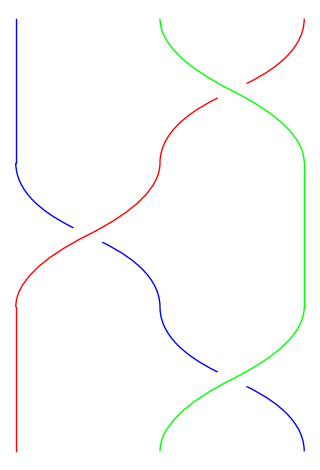

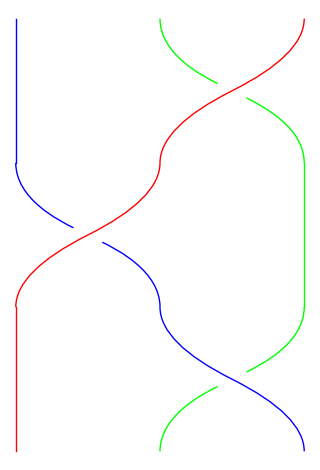

[
[ 1 -1]  [1 0]  [ 1 -1]
[ 0  1], [1 1], [ 0  1]
]

In [14]:
meow = G_gens[1]*G_gens[0]*G_gens[1]**(-1)
meow2 = G_gens[1] ** (-1) *G_gens[0]*G_gens[1]
meow.plot().show()
meow2.plot().show()
twist_rho(meow)

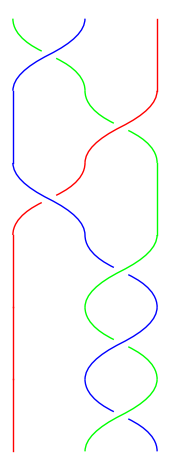

In [18]:
(G_gens[1]**3 * G_gens[0]**(-1) * G_gens[1] * G_gens[0]).plot()

## Specific Group Theory

In [23]:
def construct_Gn(n):
    if n >= 5:
        return None
    (Gr, gens, _, _, _,BGroup) = construct_orbit_hood(n,M=100)
    #display_orbit(Gr,gens).show()
    stab_gens = build_stab_gens(Gr,gens)
    Gn = BGroup.subgroup(stab_gens)
    return (Gn,stab_gens, BGroup)



In [13]:
(G3, G3_gens, B3) = construct_Gn(3)
B3_gens = B3.gens()
antinodals_G3 = [B3_gens[0]**3, 
                 B3_gens[1]**3, 
                 conj(B3_gens[0]**3, B3_gens[1]**(-1)),
                 conj(B3_gens[1]**3, B3_gens[0])]
equinodals_G3 = [conj(B3_gens[1], B3_gens[0]**(-1)),
                conj(B3_gens[0],B3_gens[1]),
                conj(B3_gens[1],B3_gens[1]**(-1) *B3_gens[0]),
                conj(B3_gens[0],B3_gens[0]*B3_gens[1]**(-1))
               ]
# Sanity check
assert(all([braid_in_img(b) for b in equinodals_G3]))
assert(all([braid_in_img(b) for b in antinodals_G3]))

equi_squares_G3 = [b**2 for b in equinodals_G3]
anti_squares_G3 = [b**2 for b in antinodals_G3]
G3
equi_squares_G3
#H3 = G3.quotient(equi_squares_G3 + anti_squares_G3)

[σ0^-1*σ1^2*σ0, σ1*σ0^2*σ1^-1, σ1^-1*σ0*σ1^2*σ0^-1*σ1, σ0*σ1^-1*σ0^2*σ1*σ0^-1]

In [1]:
(G4, G4_gens, B4) = construct_Gn(4)
#G4_gens

NameError: name 'construct_Gn' is not defined

## Chain Complexes

In [14]:
from sage.topology.simplicial_complex import SimplicialComplex
from sage.modules.with_basis.morphism import ModuleMorphismFromFunction, ModuleMorphismByLinearity

(Gr3, gens3, _, _, _,BGroup) = construct_orbit_hood(3,M=70)

def build_chain_cx_edges(zero_chains, one_chains):
    zero_basis = zero_chains.basis()
    one_basis = one_chains.basis()
    def single_edge(edge):
        (s, t, name) = edge
        return zero_basis[t] - zero_basis[s]
    return ModuleMorphismByLinearity(domain=one_chains, codomain=zero_chains,on_basis = single_edge)

def create_relation_path(Gr, gens, v, i, j):
    if abs(i-j) > 1:
        lst = [(gens[i],1), (gens[j], 1), (gens[i],-1), (gens[j],-1)]
        return path_from_genlst_noswp(Gr, lst, v)
    else:
        lst1 = [(gens[i],1), (gens[j],1), (gens[i],1)]
        lst2 = [(gens[j],-1), (gens[i],-1), (gens[j],-1)]
        return path_from_genlst_noswp(Gr, lst1 + lst2, v)

def build_chain_cx_faces(Gr, gens, one_chains,two_chains):
    one_basis = one_chains.basis()
    two_basis = two_chains.basis()
    def chain_from_path(pth):
        tot = 0
        for (e, i) in pth:
            tot += i*one_basis[e]
        return tot

    def single_face(t):
        (v,i,j) = t
        pth = create_relation_path(Gr, gens, v, i, j)
        chain = chain_from_path(pth)
        return chain
    return ModuleMorphismByLinearity(domain=two_chains, codomain=one_chains,on_basis = single_face)
    
    
def build_chain_complex(n):
    (Gr, bgens, _, _, _,BGroup) = construct_orbit_hood(n,N=2000,M=100,breadth=True)
    zero_chains = FreeModule(ZZ, Gr.vertices())
    one_chains = FreeModule(ZZ, list(Gr.edges()))

    bgens_combs = itertools.combinations(range(0,len(bgens)),2)
    two_basis = [(v, i, j) for (i,j) in bgens_combs for v in Gr.vertices() ]
    two_chains = FreeModule(ZZ, two_basis)

    bdry_1_to_0 = build_chain_cx_edges(zero_chains,one_chains)
    bdry_2_to_1 = build_chain_cx_faces(Gr,bgens,one_chains,two_chains)
    
    return ChainComplex([two_chains, bdry_2_to_1.matrix(), one_chains, bdry_1_to_0.matrix(), zero_chains])
    
    if n >= 5:
        return None

In [15]:
build_chain_complex(4).homology()

{0: Z^28, 1: Z x Z, 2: Z}

Finitely presented group < e0, e1, e2, e3, e4, e5, e6, e7, e8 |  >

In [ ]:
gens3[0].

## Finding Big Intersection

In [163]:
(Gr, gens13, reps13, timeout,comp_verts,_) = construct_orbit_hood(7,N=1000,M=1000,breadth=True)

In [139]:
def max_int(rho):
    return max(adj_int_numbers(rho))

lst_bigs = [(rho, max_int(rho)) for rho in reps13 if max_int(rho) > 2]
print(len(lst_bigs))
#lst_bigs_better = [rho for rho in lst_bigs if A in rho]
#nice_rep = lst_bigs[0][0]
#meow = Gr.shortest_simple_paths(0,32,report_edges=True,labels=True)

#pth = next(meow)
#pth
#new_rep = nice_rep
#nice_rep
#pth
#reps5.index(nice_rep)
#pth
#lst_bigs

0


In [164]:
def max_all_int(rho):
    return max(all_int_numbers(rho))
lst_bigs = [(rho, max_all_int(rho)) for rho in reps13 if max_all_int(rho) > 2]
print(len(lst_bigs))

222


3


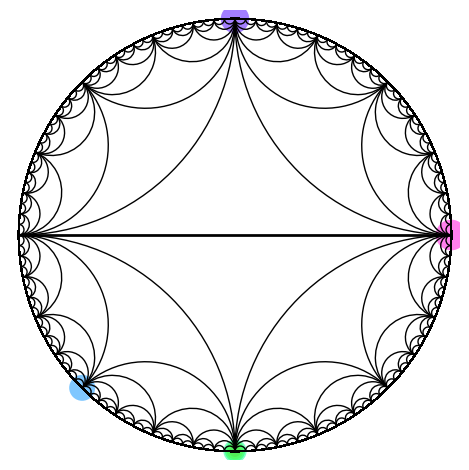

3


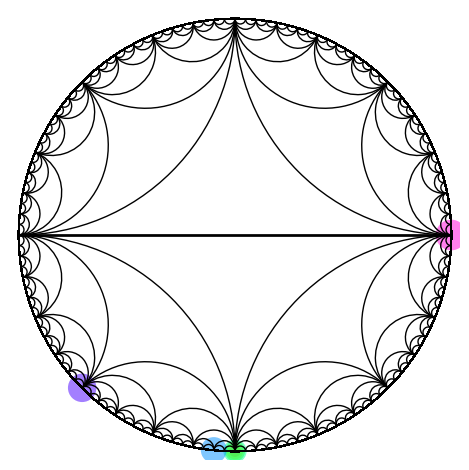

5


KeyError: (-13, 11)

In [185]:
nice_rho = twist_rho(gens13[3]*gens13[2]*gens13[1],lst_bigs[0][0])
scc_rep(nice_rho)
g = gens13[-2]
for i in range(0,3):
    print(max_int(twist_rho(g**i,nice_rho)))
    farey_rho(twist_rho(g**i,nice_rho),preloaded=preloaded).show()
#,preloaded=preloaded)

## Farey Fun

In [57]:
H = HyperbolicPlane()
preloaded = farey_complex(H,6,make_dict=True)
lst_braids = [G_gens[3], G_gens[0],G_gens[0],G_gens[1]] + [G_gens[2]]*10
new_rho = rho_std(5)
many_rhos = [new_rho]
for g in lst_braids:
    many_rhos.append(twist_rho(g,rho=many_rhos[-1]))

In [ ]:
farey_rho(new_rho,preloaded=preloaded).show()
for g in lst_braids:
    new_rho = twist_rho(g,rho=new_rho)
    farey_rho(new_rho,preloaded=preloaded).show()

In [71]:
for r in many_rhos:
    for x in scc_rep(r):
        if x[1][0] != 0 and x[0][0] != 0:
            print(x[0][0]/x[1][0])
            print(farey_dist_infty(x[0][0]/x[1][0]))

1
1
-1
1
1
1
-1
1
1
1
-1
1
1
1
-1/3
3
-1
1
-1/5
3
-1/3
3
-1/7
3
-1/5
3
-1/9
3
-1/7
3
-1/11
3
-1/9
3
-1/13
3
-1/11
3
-1/15
3
-1/13
3
-1/17
3
-1/15
3
-1/19
3
-1/17
3
-1/21
3
-1/19
3


In [69]:
((-1/3).continued_fraction())[0]

-1

# QuasiIsom Tests

In [64]:
K = 8
collect_many = [many_rand_stretch(H_gens[0]**i, M=50, N=1000000, printer=False) for i in range(-K,K)]

[18.0, 15.9, 14.1, 12.2, 8.46, 7.58, 4.92, 2.36, 1.00, 2.56, 4.85, 7.12, 9.48, 11.2, 15.2, 16.5]


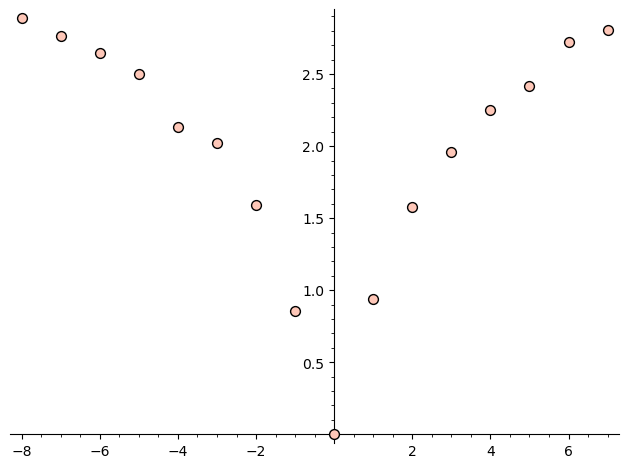

In [65]:
print(collect_many)
scatter_plot(many_logged)

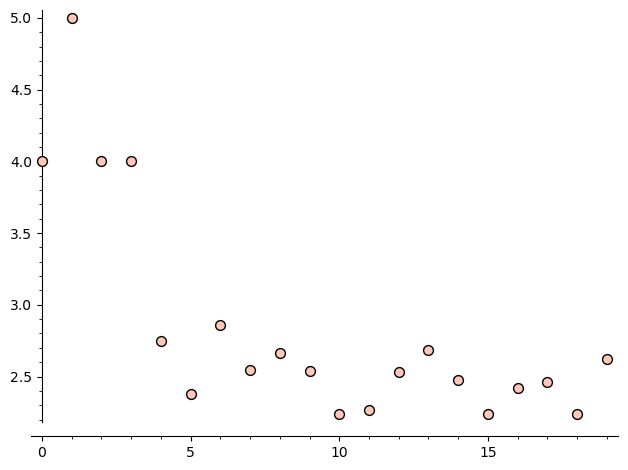

In [72]:
many_N = [many_rand_stretch(H_gens[0], M = 100, N = 2**n,printer=False) for n in range(0,25)]
scatter_plot(list(zip(range(0,20),many_N)))

In [95]:
many_N

NameError: name 'many_N' is not defined

In [121]:
A = matrix([[1,-1],[0,1]])
B = matrix([[1,0],[1,1]])
fixed_qs = [4,0]
many_rand_ps = sum([rand_ps(5,N=5**i) for i in range(0,10)],[])
pss = [list(ps) for ps in itertools.combinations(many_rand_ps,2)]
calc_stretches = [numerical_approx(braid_stretch(H_gens[0], fixed_qs, ps)) for ps in pss]
mmax = max(calc_stretches)
print(mmax)
pss[calc_stretches.index(mmax)]

5.00000000000000


[+Infinity, 0]

In [122]:
apply_braid_rat(H_gens[0],[4,0])

[16/3, 4]

In [113]:
apply_braid_rat(H_gens[0],[Infinity,0])

[-1, +Infinity]

In [124]:
farey_dist(16/3,-1)

4

In [15]:
apply_braid_rat(H_gens[0]**20,[-1,1])

KeyboardInterrupt: 

In [77]:
mmeow = []
keep = rand_ps(200,N=2**100000)
for p in keep:
    meow1 = [0,p]
    meow2 = [Infinity,p]
    mmeow.append(numerical_approx(braid_stretch(H_gens[0],meow1,meow2)))
meow_max = max(mmeow)
print(meow_max)
keep[mmeow.index(meow_max)]

32.0000000000000


-528471533/74049125

# Level 2 Graphs

In [16]:
import networkx as nx

def clean_graph(file_name):
    nx_gr = nx.drawing.nx_pydot.read_dot(file_name)
    edge_list = list(nx_gr.edges(keys=True))
    edge_list_edit = [(u,v,k[0] + str(int(k[1])-1)) for (u,v,k) in edge_list]
    new_graph = DiGraph(edge_list_edit,loops=True,multiedges=True)
    N = len(new_graph.vertices())
    new_graph.relabel(dict([(str(i),i) for i in range(0,N+1)]))
    return new_graph

def build_gens(n,p,file_name,with_inv=True):
    if not(with_inv):
        print("Not implemented without inversion from OG graph")
        return
    gr = clean_graph(file_name)
    B = BraidGroup(n, 'a')
    B_gens = B.gens()
    lcos = build_lcosets(gr,[b**(-1) for b in B_gens])
    rcos = rcosets_from_lcosets(lcos)
    return gens_from_rcosets(B_gens, rcos, pred=lambda b: braid_in_img_p(b,p=p))

level_2_five_punct = clean_graph('./level_2_five_punct_graph')

In [52]:
B5 = BraidGroup(5,'a')
B5_gens = B5.gens()
the_graph = clean_graph('./gen_graphs_2s/5-3-out.graph')
the_graph

Looped multi-digraph on 240 vertices (use the .plot() method to plot)

In [ ]:
seven_two_gens = set(build_gens(7,2,'./gen_graphs_2s/7-2-out.graph'))

In [ ]:
five_seven_gens = set(build_gens(5,7,'./five_seven.out'))

In [ ]:
five_seven_gens

In [ ]:
level_2_five_equianti = get_equi_antinodals(level_2_five_punct, 0, [b for b in B5_gens])

In [45]:
#lst_cands = []
#many_braids = lots_of_braid(B5_gens,6)
#many_reps = [twist_rho(b) for b in many_braids]

In [52]:
g = B5_gens[1] * B5_gens[0]**2 * B5_gens[3]
braid_in_img(g**(-1) * B5_gens[2]**1 * g)

False

In [65]:
h = B5_gens[0]**2*B5_gens[2]*B5_gens[1]**2*B5_gens[2]*B5_gens[3]*B5_gens[2]*B5_gens[3]**(-1)*B5_gens[1]**(-2)*B5_gens[3]**(-1)*B5_gens[2]**(-1)*B5_gens[0]**(-2)

In [67]:
braid_in_img_p(h)

True

In [64]:
h

(a0^2*a2*a1^2*a2*a3*a2*a3^-1*a1^-2*a3^-1*a2^-1*a0^-2,)

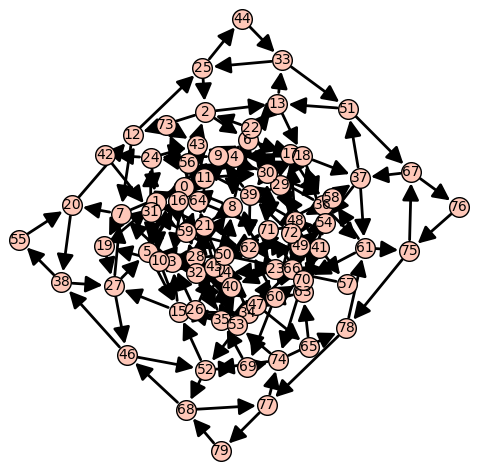

In [6]:
level_2_five_punct.remove_loops()
level_2_five_punct.plot()

In [28]:
A1 = matrix([[1,1],[0,1]])
A2 = matrix([[1,0],[1,1]])
A3 = matrix([[1,0],[0,1]])
A4 = matrix([[1,1],[1,0]])
A5 = matrix([[0,1],[1,1]])
A6 = matrix([[0,1],[1,0]])
mod_2_sl2 = [A1,A2,A3,A4,A5,A6]
pos_reps = [[a,b] for a in mod_2_sl2 for b in mod_2_sl2]
#[braid_in_img_p(BraidGroup(2).gens()[0]**3, rho=rep,p=2) for rep in pos_reps]

In [14]:
#[braid_in_img((B5_gens[0]* B5_gens[1]*B5_gens[2])**4 ,rho=rep) for rep in reps5]